# Reinforcement learning - Training an artificial intelligence (AI) to play a video game

**Artifical intelligence (AI) in video games** is often criticised for its **approximations** or **aberrant behaviours** that break the player's immersion. This AI is traditionally "hard coded", so that the AI entity (a NPC - Non-Playable Character - or an enemy for example) will behave according to **predefined rules**, making it very predictable in its actions.

In the 1990s, the emergence of **deep learning** (and especially of **increased computational capacity**) found an application in AI through **reinforcement learning**. This branch seeks to **copy the learning mechanism of a human to adapt it to an AI**, making the latter more "intelligent" and able to adjust to new situations.

The idea? **Confront an AI (usually called an "agent") with no knowledge or prior knowledge with a video game**, and **let it learn from its mistakes** in an autonomous way thanks to the **rewards or penalties** that it will be given following its actions and their results.

This is essentially what we tried to do in this project, using the **Gym** library, developed by one of the big names in the sector, **OpenAI**, which allowed us to simulate the environment of the game **Activision Tennis**, released in 1980 on the Atari 2600.

We will, of course, see the process in detail, but the principle is as follows: our agent's only initial reference point is the **list of actions it can undertake**. First, we give it an **initial image of the game**, which is literally a freeze frame of the latter. The agent is asked to select the **most appropriate action**: move right, left, diagonally, shoot etc. This action is passed on to the game and the game moves on to the next image (called **"state"**), which is again passed on to the agent. At the end of the point (as a reminder, the game is a tennis game), the agent is told by the **score** whether it has won or not. 

**Our agent integrates this experience and draws conclusions from it**: depending on the outcome of the point, it will **modify the probability of choosing a particular action via bonuses/maluses**. Little by little, just like a human would do for a video game or tennis, it will learn from its mistakes and constantly improve, until it reaches a level comparable (or even superior) to that of a human.

That's it for the main lines. If you are interested in the subject, the Internet is full of **articles explaining it in much more detail**! 

Before going any further, we feel it is important to point out that among the many resources we have used, **[Game of Dimension's work on the game Pong](https://github.com/gameofdimension/policy-gradient-pong/blob/master/policy_gradient_pong.py)** stands out, and we have drawn heavily on it.

For the French speakers among you, don't hesitate if you want a more "visual" introduction to this project to watch the **[replay of the presentation](https://www.youtube.com/watch?v=XefhnowWji4&t=8210s)** that my classmate Chunyan Frey and I made about it.

Ready to go?

### Prerequisites

Before we get to the heart of the matter, let's discuss what you need for this project.

As our agent learn from its experiences, there is **no pre-existing dataset**, so all you'll need is the **notebook** provided. However, as explained in the **README file** of this project, please remember that although the code is working, **we haven't been able to complete the training of our agent** for time reasons and are thus unsure of the results.

In case you would like to complete the training yourself, **several options** are available: running the notebook on your **own computer** (if the latter is powerful enough), executing the code in a Python script through a **cloud solution** (Amazon SageMaker or Google Cloud Platform for example) or splitting the training in several parts thanks to the **checkpoints**.

As for **libraries**, this project uses six of them: 

- **NumPy** (data manipulation)
- **TensorFlow** (data manipulation and deep learning)
- **Gym** (video game environments)
- **time** (time access) 
- **os** (operating system interfaces)
- **Matplotlib** (data visualization)

Depending on your execution environment, you might need to **install these modules**. You can do so using a `pip install name_of_the_library` command. Remember to add an exclamation mark at the beginning if you want to execute it directly in a notebook, as it is originally a terminal command.

It is now time to begin!

### Preparing the environment

##### Installing required libraries

In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
import os
import matplotlib.pyplot as plt

##### Defining some useful functions

Our training is based on a **deep learning architecture**, and we can't feed our model with any input. We could actually, but the images wouldn't be easily understood by the model. Preprocessing the images to simplify the information it contains can thus tremendously reduce training time! Let's do this through a custom function.

In [2]:
def prepro(img):
    # Cropping the image
    img = img[40:220]
    
    # Reducing the number of pixels by 2 in width and height,
    # and removing the last channel
    img = img[::2, ::2, 0].astype(np.float)
    
    # Setting some pixels to specific values
    # This is of course not random, we did some tests to see
    # which values we had to modify.
    img[img == 168] = 0.0
    img[img == 214] = 0.5
    img[img == 117] = 1.0
    img[img == 240] = 1.0
    img[img == 74] = 0.0
    img[img == 236] = 1.0
    
    return img

I guess this is not very concrete at the moment. Let's see the **before and after** image.

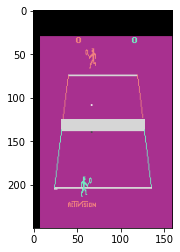

In [3]:
# BEFORE

## Creating the game environment and resetting it
## (this is mandatory to make it work)
env_tennis = gym.make("Tennis-v0")
env_tennis.reset()

## Simulating 10 frames, with 25 actions chosen randomely
## We will explain later on what are these four objects returned by the environment.
for _ in range(10):
    observation, reward, done, info = env_tennis.step(env_tennis.action_space.sample())

## Displaying the new image and closing the environment (this is a good practice)
plt.imshow(observation)
env_tennis.close()

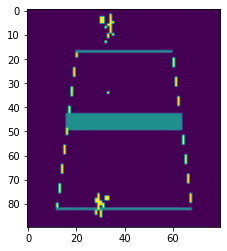

In [4]:
# AFTER

## Calling our custom function on our image
after_version = prepro(observation)
plt.imshow(after_version)

As you can notice, the image has been cropped to focus on its relevant part, and the color code has been simplified in order to **help the algorithm analysing the image**.

Another function we have to define upstream is the one establishing the **rewards policy**. This notion of reward is fundamental in reinforcement learning, since **it allows our agent to know if its actions have been successful or not**.

In its initial version, the reward is configured as follows: if the agent **wins the point**, we give it a **reward worth 1**. If it **loses the point**, **the reward is worth 0**. However, these rewards are initially given only to the **last action**.

This is where the notion of **"discounted reward"** comes into play. The idea is to **dilute the reward on all the actions that led to the conclusion** (winning the point or not). In the case of a win, the last action receives a reward of 1 multiplied by a **discount coefficient**, in our case 0.99. For the second to last action, we take this new discounted reward for the last action and multiply it once again by the discount coefficient. The reward is therefore 0.99 * 0.99, that is 0.9801. For the antepenultimate action, it will be 0.970299 (0.9801 * 0.99), and so on.

Why apply this discount and not give a reward of 1 for all actions that led to the agent winning the point? Simply because we consider that **the closer an action is to the end of the point, the more decisive it was**. If our agent has won the point, it is likely that his last moves were good, and should be encouraged.

Conversely, when our agent **loses the point**, the reward will be **-1**, and the same discount process is applied.

This system is not perfect, but in general, and by **repetition of experiences**, **the relevant actions will tend to be encouraged, and the bad actions penalized**. This is how our agent will progress!

In [5]:
# Our reward matrix is initially composed of 0 (most of the times),
# -1 or 1 (for the last actions of the points won).
# The function will replace it by its discounted version.

def discount_rewards(r):
    # Our discount coefficient
    gamma = 0.99
    
    # A "placeholder" matrix, similar in shape to the matrix passed to the function but filled with 0
    discounted_r = np.zeros_like(r) 
    
    # The last reward granted, initialized at 0
    running_add = 0
    
    # Looping backwards over our reward matrix, starting from its last element
    for t in reversed(range(0, len(r))):
        # Checking if the selected element is different from 0 
        # If it is the case, we replace the current state of the reward by the element (1 or -1).
        # As our matrix contains rewards for several points, this will allow 
        # us to reinitialize the discounting process every time we encounter
        # a 1 or -1 in the original matrix, which indicates that this is a different point.
        if r[t] != 0: running_add = r[t]
        
        # Applying our discount coefficient to the current state of the reward
        running_add = running_add * gamma
        
        # Replacing the element in our placeholder matrix by the calculated value
        discounted_r[t] = running_add
        
    # Once the loop is over, we want to return the discounted matrix.    
    return discounted_r

The last function that we will have to define before entering the heart of the matter refers to the **architecture of the model that we will use to select the actions to be performed at each step**. This model is based on **deep learning** and is quite simple since it is composed of **two dense layers**. 

In [6]:
def make_network(pixels_num, hidden_units, action_number):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_units, activation = "relu", input_shape = [pixels_num]),
        
        # We want to output a probability for each possible action, so our last layer
        # contains a number of neurons equals to the number of possible actions.
        tf.keras.layers.Dense(action_number, activation = "softmax")
        ])
    return model

##### Setting the values of some variables

Last step before starting the training: we need to **define some variables and parameters**. This is not systematically necessary, but **it simplifies the training loop** and makes the **different parameters easily adjustable** for other experiments.

In [7]:
# Number of pixels of our images after transformation
pixels_num = after_version.shape[0] * after_version.shape[1]

# Number of neurons in the first dense layer of our model
hidden_units = 200

We will also need the **number of actions** our agent can make in the game, as this will determine the **number of neurons of the last layer of our model**. We can't retrieve this number directly due to the way the library is coded, but we can display it and save it in a new variable.

In [8]:
# Initializing the simulation of our game
# Note: you can easily adapt this notebook to another game, feel free to visit OpenAI Gym's 
# documentation (https://gym.openai.com/envs) to see which games are available!
env = gym.make("Tennis-v0")

# Displaying the number of available actions
env.action_space

Discrete(18)

In [9]:
# Saving the displayed number in a variable

action_number = 18

##### Initializing our model

In [10]:
# Creating our deep learning model, using the function defined earlier
model = make_network(pixels_num, hidden_units, action_number)

# Instantiating an Adam optimizer with a learning rate of 0.001
model_optimizer = tf.keras.optimizers.Adam(lr = 1e-3)

### Training the agent

We are now ready to move on to the longest and most complex phase of the project: the **training of the agent**. Some cells, such as the training loop itself, will be particularly dense, but I'll go through it **step by step**.

##### Reloading from the last checkpoint

As mentionned at the beginning of this notebook, **training an AI agent can be very long**. Hence the utility of **configuring checkpoints**! The latter will be done directly in the training loop, all we have to do for now is **deciding whether or not we want to resume from a previous save**, and loading the corresponding elements if the answer is positive.

In [11]:
# If it's the first time you launch the training, the `resume` variable must be set to False. 
# If you want to resume from a checkpoint, all you need to change in the whole notebook is
# setting it to True! And verifying you have all the required files in the right folder, obviously.
resume = False

In [12]:
# Managing the checkpoints' directory

## Defining the desired relative path of our directory
checkpoint_dir = "./checkdir"

## Creating the directory if it doesn't exist yet
if not(os.path.isdir(checkpoint_dir)): os.mkdir(checkpoint_dir)
    
## Setting 'ckpt' as the prefix of each save file 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

## Making the checkpoint process ready for use
checkpoint = tf.train.Checkpoint(model = model, optimizer = model_optimizer)

In [13]:
# Performing several commands if 'resume' has been set to True

if resume:
    ## Loading the latest save file
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)
    
    ## Getting the corresponding model and optimizer
    model = checkpoint.model
    model_optimizer = checkpoint.optimizer
    
    ## Looking for the training step number (more on this further on) in the name of the checkpoint
    start = latest.find("ckpt-") + 5
    last_step = int(latest[start:])

##### Initializing a few variables

Before launching the training loop, we have (once again) to **initialize some variables and objects**!

But first, we have to come back to something. Remember earlier, when I said that I would explain the line `observation, reward, done, info = env_tennis.step(env_tennis.action_space.sample())`? It's time now, as this will be required to understand the following cells.

Let's first simplify this command, to make it clearer. `env_tennis.action_space.sample()` just gives us a **random number** between 0 and 17, which corresponds to **one of the available actions in the game** (move right, shoot, move back etc.). To understand the whole line, we don't care about the action taken, so we'll just replace this bit by an integer (for example 4).

A **simplified version** of the command would then be `observation, reward, done, info = env_tennis.step(4)`. Easier to read, but what does this mean? Let's first focus on `env_tennis.step(4)`. This means that we take the **current state of our environment (our simulation) and make it evolve through an action** (here action number 4). This `step` function will return four elements, that we store in **four variables** located on the left part of the command:
- `observation`: the **next image**. Once our action is made, the environment will move to **another state** and thus a **new observation**! Once again, picture it as a game that would be displayed **frame by frame**. At each frame, our agent decides which action to implement. We move on to the next frame, and so on.
- `reward`: the **reward** associated with the action taken. As mentionned before, **this will be 0 in most cases**, except when the point is done (it will then be 1 or -1 depending on the result - but this only happens once in a while!).
- `done`: taking the value True or False, this variable indicates **whether or not the game is finished**. This will be False most of the times, except on the last frame.
- `info`: gives more information on the state of the environment. We won't use this.

One last thing I have to say concerns the **length of an episode**. The latter corresponds to the duration of a **match**, which in Activision Tennis lasts **one set**. It is not essential to know this, but for those of you who are not familiar with tennis, a set is simply a **collection of games** (four points or more), played until a player wins six games or more. 

To summarize, in the rest of this notebook, the terms **"episode"** and **"match"** will be **strictly equivalent**.

OK, now most of the next cells will make much more sense to you! Not everything though, I'll elaborate on some points afterwards.

In [14]:
# Indicating that when we start an episode, there is no previous observation
prev_x = None

In [15]:
# Setting the batch size, a.k.a. the number of episodes before updating the weights of the model
# our agent uses to select the best actions to implement at each observation.
# This refers to the very foundations of deep learning: the model is optimized over the course 
# of iterations by updating the weights of each neuron. 
# Here, we will ask our agent to play 10 matches, and then we will update 
# the weights of the model to integrate what it has learned on this interval.
batch_size = 10

In [16]:
# Creating several empty lists that will contain respectively:
# - all the observations of a batch (x_ba)
# - the indexes of all the actions taken in an batch (act_ba)
# - all the rewards obtained by our agent during an episode (not the whole batch!), before discount(rew_ep)
# - all the rewards obtained by our agent during the batch, after discount(dis_rew_ba)
x_ba = []
act_ba = []
rew_ep = []
dis_rew_ba = []

In [17]:
# Indicating the current training step (loading it from the checkpoint files or 
# setting it to 0), as well as the current episode number. This part might still 
# seem obscure, but I'll get back to it. For know, just remember that a step
# is composed of 10 episodes.
step = last_step if resume else 0
episode_number = step * 10

In [18]:
# Initializing the video recorder, which will help us assess the evolution
# of our agent! We specify as arguments of the function what we want to record,
# where we want to save the results and when to record.
# Here we chose to record a video every 500 episodes, in order to to avoid 
# using too much memory for storage. Remember that the training will last for 
# days, so you don't want to overload your storage space!
env = gym.wrappers.Monitor(env, 
                           "recording/", 
                           video_callable = lambda episode_number: episode_number % 500 == 0, 
                           force = True)

In [19]:
# Resetting the environnement before starting
observation = env.reset()

In [20]:
# Stating that the initial reward mean equals to -24.
# This represents the worst result for our agent. At first, it is inexperienced and is likely to lose 
# all the points played. Given that a player needs to win 6 games, themselves composed of at least 
# 4 points, to win a match, we can expect our agent to receive a total reward of 6 * 4 * -1 = -24.
# Our objective will be to improve this score: our agent will start to win more and more points,
# so we can expect its score to increase. The perfect score would be +24, but we don't
# need such a high level of performance.
reward_mean = -24

##### Launching (finally!) the training loop

That's it, we can finally **start the training loop**! 

The following is probably the **most complicated part** of the project, but rest assured that it is the last.

Also, what we have already discussed combined with the upcoming code comments should allow you to understand it all without too much trouble.

By the way, don't worry about the huge **error message** in the output, it's just because I **manually stopped the execution of the cell**. I just wanted to give you an example of what you'll get, but this is far from being the whole training.

Otherwise, if you get **outliers** regarding the **frame size** (typically 10000 for several iterations, which is the cutoff value), consider maybe **restarting the training**. Indeed, this may mean that the agent has gone in a **wrong direction of learning** from the beginning, which will be difficult (and especially very long) to rectify.

Also, don't be alarmed if **`reward_mean` fluctuates up and down**, this is perfectly **normal in the short term**. It will have an **upward trend in the long run**.

Ready to dive in?

In [21]:
# We're using a while loop here, making it run indefinitely
# (not really actually, as we will introduce a break condition later on)
while True:
    # Applying our preprocessing function to the observation
    cur_x = prepro(observation)
    
    # A technical detail: the model doesn't really take into account an observation 
    # but the difference between the observation at time t and that at t-1.
    # If we are at the beginning of a match, there is no observation at t-1,
    # so we consider that the latter is just a blank image.
    x = cur_x - prev_x if prev_x is not None else np.zeros((pixels_num))
    
    # Setting the current observation as the one that should be used 
    # as the previous one in the next iteration. 
    prev_x = cur_x
    
    # Deleting objects that are no longer needed, in order to 
    # unclutter the memory (we will do this a couple of times) 
    del observation
    del cur_x

    # Reshaping the observation to make it understandable by the model
    x = tf.reshape(x, shape = [1, -1])

    # Using the model to select the best possible action given the current situation
    # What we get thanks to the model is a matrix of probabilities, which represent
    # roughly the chance of each action to be the most relevant.
    # We then use Numpy's argmax function to get the index of the action with the highest probability.
    tf_probs = model(x)
    action_index = np.argmax(tf_probs)
    del tf_probs

    # Making the environment move to the next state. We talked about it before,
    # but to make it short, we ask the environment to apply the action selected
    # and move to t+1. We recover some objects, including the next observation
    # and the reward our agent got on the current observation.
    observation, reward, done, _ = env.step(action_index)
    
    # Adding the current observation, the action index and the reward obtained
    # to the lists we created previously.
    x_ba.append(x)
    act_ba.append(action_index)
    rew_ep.append(reward)

    # All the previous operations will be repeated for each observation of an episode (and then of a batch).
    # Let's now see what happens when the environment returns the value "True" for 
    # the 'done' object, i.e. when the episode is over.
    if done:
        # Adding 1 to the episode count
        episode_number += 1
        
        # Replacing the matrix of rewards of the episode by its discounted version.
        # We also normalize the matrix, and we add the result to the list we created earlier.
        discounted_ep_rew = discount_rewards(rew_ep)
        discounted_ep_rew -= np.mean(discounted_ep_rew)
        discounted_ep_rew /= np.std(discounted_ep_rew)
        dis_rew_ba += discounted_ep_rew.tolist()
        del discounted_ep_rew

        # Updating the reward mean (which is -24 in the beginning) with the score of the episode.
        # We give the latter a small importance in order to make the results more consistant.
        # In other words, we make the 'reward_mean' object less sensitive to variations 
        # and therefore more stable and relevant in the long run.
        reward_mean = 0.99 * reward_mean + (1 - 0.99) * sum(rew_ep)

        # Reinitializing the episode reward list for the next iteration
        rew_ep = []
        
        # In order to limit training time, we considered that the whole loop should 
        # stop if 'reward_mean' exceeds 5, as this means our agent is good enough. 
        # Believe me, I played the game and beating the game's AI is already a great achievement!
        if reward_mean > 5.0:
            break

        # Each time we reach the end of a batch (10 episodes in our case), we modify our model 
        # to integrate what the agent has learned during the batch.
        # This is the heart of the learning process!
        if episode_number % batch_size == 0:
            # Adding 1 to the training step count
            step += 1
            
            # Determining the number of observations in the batch
            frame_size = len(x_ba)
            
            # Transforming our matrixes of observations, actions and rewards to 
            # make them understandable by TensorFlow.
            x_ba = np.vstack(x_ba)
            act_ba = np.vstack(act_ba)
            dis_rew_ba = np.vstack(dis_rew_ba)
            
            # To ease things, we'll collect information from 
            # our batch by bits of 20,000 observations.
            # 'pos' will refer to the latest position in our partition.
            stride = 20000
            pos = 0

            # Infinite loop that will only break when we reach the end of the batch
            while True:
                # Setting the end of the current bit at 20,000 (or less if we're at the end of the batch)
                end = pos + stride if pos + stride < frame_size else frame_size

                # Selecting the observations, actions and rewards of the bit
                x_bit = x_ba[pos:end]
                act_bit = act_ba[pos:end]
                rew_bit = dis_rew_ba[pos:end]

                # Time to update the model with this new information through a gradient descent,
                # with the help of TensorFlow's GradientTape function.
                with tf.GradientTape() as tape:
                    # Calculating the cross entropy using as true values the actions taken
                    # (this is a huge difference from classical machine learning, as we have
                    # no preexisting data) and as predicted values what the model predicts
                    # for the same observation.
                    cross_entropy = tf.losses.sparse_categorical_crossentropy(act_bit, 
                                                                              model(tf.reshape(x_bit, shape = [len(x_bit), pixels_num])))
                    
                    # Calculating the loss by comparing the rewards and the cross entropy
                    loss = tf.reduce_sum(tf.multiply(rew_bit, cross_entropy))
                    
                    # Compiling everything...
                    gradient = tape.gradient(loss, model.trainable_variables)
                    
                    # ... and updating our model's weights!
                    model_optimizer.apply_gradients(zip(gradient, model.trainable_variables))
                
                # Indicating that the next iteration will have to start
                # where the previous one ended
                pos = end

                # Breaking the loop if reaching the end of the batch
                if pos >= frame_size:
                    break
            
            # Once all the batch has been processed, we prepare the ground for the next batch!
            del x_bit
            del act_bit
            del rew_bit
            x_ba = []
            act_ba = []
            dis_rew_ba = []
                
        # Every 5 batches, we will save the current state of the model.
        if episode_number % (batch_size * 5) == 0:
            # Saving the elements according to what was initially set up
            checkpoint.save(file_prefix = checkpoint_prefix)
            # Displaying information to help us track the progress
            print("{} - episode: {}, epoch: {}, frame size: {}, reward mean: {}".\
                  format(time.strftime("%H:%M:%S, %d %b %Y"), episode_number, step, frame_size, reward_mean))
            
        # Resetting the environment in order to start a new episode
        observation = env.reset()

# Closing the environment if our whole loop stops (i.e. if 'reward_mean' becomes superior to 5)
env.close()

13:46:41, 10 Jun 2021 - episode: 50, epoch: 5, frame size: 23297, reward mean: -23.919810302364787
13:52:01, 10 Jun 2021 - episode: 100, epoch: 10, frame size: 24322, reward mean: -23.928444191289664
13:57:28, 10 Jun 2021 - episode: 150, epoch: 15, frame size: 24609, reward mean: -23.93317919703471
14:03:09, 10 Jun 2021 - episode: 200, epoch: 20, frame size: 23604, reward mean: -23.913558671443646
14:09:20, 10 Jun 2021 - episode: 250, epoch: 25, frame size: 23597, reward mean: -23.92666234368268
14:15:32, 10 Jun 2021 - episode: 300, epoch: 30, frame size: 23943, reward mean: -23.92075328202214
14:21:42, 10 Jun 2021 - episode: 350, epoch: 35, frame size: 23893, reward mean: -23.91659337097026
14:28:02, 10 Jun 2021 - episode: 400, epoch: 40, frame size: 24629, reward mean: -23.902563522623367
14:34:17, 10 Jun 2021 - episode: 450, epoch: 45, frame size: 24141, reward mean: -23.9165167163315
14:40:35, 10 Jun 2021 - episode: 500, epoch: 50, frame size: 24435, reward mean: -23.94224230351642

KeyboardInterrupt: 

After **several days of practice**, your agent should reach a sufficient level to consider that **it has learned to play the game**.

Although the latter is quite simple and the actions are relatively few (which allowed us to use a simple model), **the training is still very long compared to what we see in machine learning**.

So I let you imagine what it could be like to train an agent on a real-time strategy game for example!

This brings us to one of the **limits of reinforcement learning**: it's a field that requires a lot of **time** and **large computing capacities**. Behind all the large-scale projects in this field, which have received the most media coverage, are dozens of people and computers.

This isn't the case here, but reinforcement learning is typically the kind of problem that benefits from the contributions of **distributed computing**.

Ultimately, it's the **rules of the game** and the **range of possible actions** that will determine the complexity of training an agent.

This project is just one practical case of reinforcement learning among others. It is possible to explore **many other horizons**, whether it be in terms of the basic material (OpenAI offers environments for [many other games](https://gym.openai.com/envs)), the deep learning model, the learning method etc. Have fun!